In [9]:
# Library
import nltk
import random
import re
import csv
import gensim
import warnings 
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_extraction, manifold
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
from sklearn.metrics import cohen_kappa_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings('ignore') # to ignore deprecated functions


In [10]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuting/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Selection
Take five different samples of Gutenberg digital books, which are all of five different genres and of five different authors, that are semantically different.

So we choice:
- Peter Pan by J. M. Barrie, and genre: Children's Literature. Semantic category: Fantasy, Adventure.
- The Origin of Species by Charles Darwin, and genre: Science. Semantic category: Evolution, Biology, Genetics.
- War and Peace by Leo Tolstoy, and genre: Historical Fiction. Semantic category: War, Society, History.
- Pride and Prejudice by Jane Austen, and genre: Romance Fiction. Semantic category: Romance, Social class, Society.
- The Adventures of Sherlock Holmes by Arthur Conan Doyle, and genre: Mystery. Semantic category: Detective, Crime, Logic, Deduction, Suspense.

In [11]:
# Define the URL and filenames for each book
books = [ 
         {"url": "https://www.gutenberg.org/files/16/16-0.txt", "filename": "Peter_Pan.txt", "author": "J. M. Barrie", "genre": "Children's Literature"},
         {"url": "https://www.gutenberg.org/cache/epub/1228/pg1228.txt", "filename": "On_the_Origin_of_Species.txt", "author": "Charles Darwin", "genre": "Science"},
         {"url": "https://www.gutenberg.org/cache/epub/2600/pg2600.txt", "filename": "War_and_Peace.txt", "author": "Leo Tolstoy", "genre": "Historical Fiction"},
         {"url": "https://www.gutenberg.org/cache/epub/1342/pg1342.txt", "filename": "Pride_and_Prejudice.txt", "author": "Jane Austen", "genre": "Romance Fiction"},
         {"url": "https://www.gutenberg.org/files/1661/1661-0.txt", "filename": "The_Adventures_of_Sherlock_Holmes.txt", "author": "Arthur Conan Doyle", "genre": "Mystery"},
]


# Download and save each book
for book in books:
    url = book["url"]
    filename = book["filename"]
    author = book["author"]
    genre = book["genre"]
    urllib.request.urlretrieve(url, filename)
    print(f"{filename} by {author} has been saved.")

Peter_Pan.txt by J. M. Barrie has been saved.
On_the_Origin_of_Species.txt by Charles Darwin has been saved.
War_and_Peace.txt by Leo Tolstoy has been saved.
Pride_and_Prejudice.txt by Jane Austen has been saved.
The_Adventures_of_Sherlock_Holmes.txt by Arthur Conan Doyle has been saved.


# Data Prepare and Preprocess

In [12]:
def sample_digital_book(book_name, num_partitions, size_partition):
    
    # Download the digital book from the local directory
    book_file = open(book_name, "r", encoding='utf-8')
    book = book_file.read()
    book_file.close()

    # use 'word_tokenize' function to tokenize the book into words.
    partitions = nltk.word_tokenize(book)
    partitions = [partitions[i : i+size_partition] for i in range(0, len(partitions), size_partition)]
    
    # Check num_partitions is valid
    if num_partitions > len(partitions) or num_partitions < 0:
        num_partitions = len(partitions)
    partitions = partitions[:num_partitions]
    
    # Create labels
    labels = [book_name[:1]]
    # Repeat the labels for the number of times that can fit in the partitions
    label_list = labels*(num_partitions//len(labels))
    # Get the remainder labels that are needed.
    label_list += labels[:num_partitions%len(labels)]
    
    # Use regular expression to manipulate the text
    # and the regular expression r'[^\w\s]' is used to remove non-alphanumeric characters from the text.
    partitions = [[re.sub(r'[^\w\s]', '', word) for word in partition] for partition in partitions]
    
    # Remove empty strings from the list
    partitions = [[word for word in partition if word] for partition in partitions]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    partitions = [[word for word in partition if word.lower() not in stop_words] for partition in partitions]

    # Stemming
    stemmer = PorterStemmer()
    partitions = [[stemmer.stem(word) for word in partition] for partition in partitions]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    partitions = [[lemmatizer.lemmatize(word) for word in partition] for partition in partitions]

    # Create pandas dataframe to store the text data
    data = {'partition': partitions, 'label': label_list}
    df = pd.DataFrame(data) 
    
    return partitions

In [13]:
# Testing for multiple books:
book_name1 = "Peter_Pan.txt"
book_name2 = "On_the_Origin_of_Species.txt"
book_name3 = "War_and_Peace.txt"
book_name4 = "Pride_and_Prejudice.txt"
book_name5 = "The_Adventures_of_Sherlock_Holmes.txt"
book_list = [book_name1, book_name2, book_name3, book_name4, book_name5]
# If book_list > label_list, add "f","g",etc.
label_list = ["a","b","c","d","e"]
df_list = []

# samples 200 documents of each book, with 150 words records for each document. 
for i, book_name in enumerate(book_list):
    partitions = sample_digital_book(book_name, 200, 150)
    temp = pd.DataFrame({'partition': partitions, 'label': label_list[i]})
    df_list.append(temp)

df = pd.concat(df_list)
df.to_csv("books_data.csv", index=False)

# Transform

In [ ]:
# Load the data from the csv file
df = pd.read_csv("books_data.csv")

sw_nltk = stopwords.words('english')

# Convert Bag-of-Words representation using CountVectorizer
count_vectorizer = CountVectorizer(stop_words=sw_nltk)
count_matrix = count_vectorizer.fit_transform(df['partition'].to_list())

# Convert TF-IDF representation using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=sw_nltk)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['partition'].to_list())

# Perform LDA
lda_model = LatentDirichletAllocation(n_components=10)
lda_matrix = lda_model.fit_transform(count_matrix)

# Word Embeddings


# Get the feature names
feature_names_bow = count_vectorizer.get_feature_names()
feature_names_tfidf = tfidf_vectorizer.get_feature_names()
feature_names_lda = [f"topic_{i}" for i in range(lda_model.n_components)]

# Store the BOW and TF-IDF representations as separate dataframes
df_bow = pd.DataFrame(count_matrix.toarray(), columns=feature_names_bow)
print("Here is the BOW result:",df_bow)
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names_tfidf)
print("Here is the TF-IDF result:",df_tfidf)
df_lda=pd.DataFrame(lda_matrix, columns=feature_names_lda)
print("Here is the LDA result:", df_lda)


Here is the BOW result:      07  10  108  10annett  11  112  113  118  12  1228  ...  youngster  \
0     0   0    0         0   0    0    0    0   0     0  ...          0   
1     0   0    0         0   0    0    0    0   0     0  ...          0   
2     0   0    0         0   0    0    0    0   0     0  ...          0   
3     0   0    0         0   0    0    0    0   0     0  ...          0   
4     0   0    0         0   0    0    0    0   0     0  ...          0   
..   ..  ..  ...       ...  ..  ...  ...  ...  ..   ...  ...        ...   
995   0   0    0         0   0    0    0    0   0     0  ...          0   
996   0   0    0         0   0    0    0    0   0     0  ...          0   
997   0   0    0         0   0    0    0    0   0     0  ...          0   
998   0   0    0         0   0    0    0    0   0     0  ...          0   
999   0   0    0         0   0    0    0    0   0     0  ...          0   

     your_  yousit  youth  zealand  zigzag  zoologist  çela  émigré  œuvr  

# Visualization

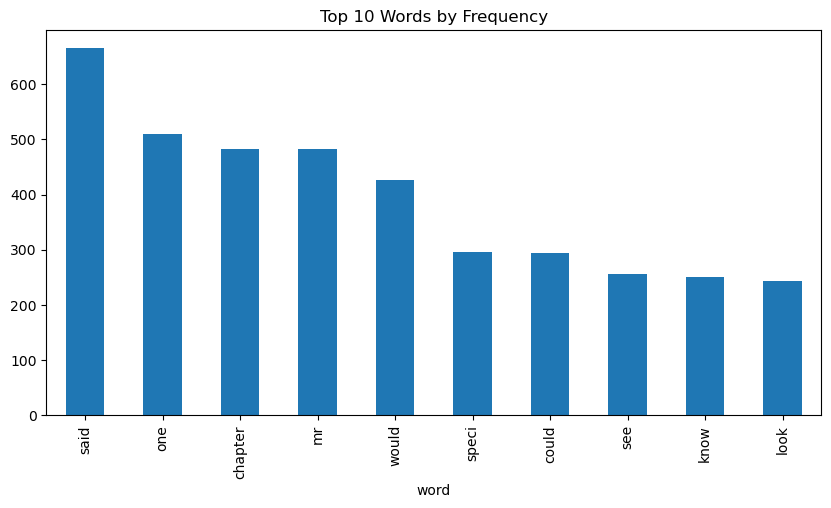

In [ ]:
# Get word frequency counts from the CountVectorizer object
word_freq = count_matrix.toarray().sum(axis=0)

# Create a dataframe of words and their frequency
word_df = pd.DataFrame({'word': feature_names_bow, 'freq': word_freq})
word_df.sort_values('freq', ascending=False, inplace=True)

# Plot the top n words
n = 10
word_df[:n].plot.bar(x='word', y='freq', legend=False, figsize=(10,5))
plt.title('Top {} Words by Frequency'.format(n))
plt.show()

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=2023)
# based on BOW
kmeans.fit(df_bow)

# get the cluster labels and add to the data frame
df_bow['cluster'] = kmeans.labels_

# print the cluster counts
print(df_bow['cluster'].value_counts())

# 随便改吧，不合适删了就行

1    578
4    210
0    160
3     46
2      6
Name: cluster, dtype: int64
